**1. INSTALL AND LOAD REQUIRED LIBRARIES**

In [1]:
# Step 1: Install librarys
!pip install -U imbalanced-learn
!pip install shap
!pip install wordcloud


In [2]:
# Step 2: Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from collections import Counter


**2. MOUNT GOOGLE DRIVE AND DATA ACCESS PATH**

In [4]:
# Step 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Step 4: Load data according to the path
file_path = '/content/drive/MyDrive/CesarIvan/UNI-A/02_RESEARCH/ARTICLES/2025/MOROCCO_ICARDA/MSC THESIS/01_DATA/MOROCCO.csv'
df = pd.read_csv(file_path, encoding='latin1')

**3. CROSS-VALIDATION FUNCTION + PREPROCESSING FOR RANDOM FOREST AND XGBOOST**

In [6]:
def cross_validate_model(df, target_var, exclude_prefixes=[], model_name="Model"):
    df_model = df.copy()
    cols_to_exclude = [col for prefix in exclude_prefixes for col in df_model.columns if col.startswith(prefix)]
    X = df_model.drop(columns=cols_to_exclude + [target_var])
    y = df_model[target_var]

    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

    class_counts = pd.Series(y_encoded).value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    mask = np.isin(y_encoded, valid_classes)
    X = X[mask]
    y_encoded = y_encoded[mask]

    imputer_num = SimpleImputer(strategy='median')
    imputer_cat = SimpleImputer(strategy='most_frequent')

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns
    if len(num_cols) > 0:
        X[num_cols] = imputer_num.fit_transform(X[num_cols])

    int_cols = X.select_dtypes(include=['int32', 'int']).columns
    if len(int_cols) > 0:
        X[int_cols] = imputer_cat.fit_transform(X[int_cols])

    smote = SMOTE(random_state=42, k_neighbors=1)
    X_bal, y_bal = smote.fit_resample(X, y_encoded)

    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    rf_scores = {
        "Accuracy": cross_val_score(rf, X_bal, y_bal, cv=kfold, scoring='accuracy').mean(),
        "F1 Score (macro)": cross_val_score(rf, X_bal, y_bal, cv=kfold, scoring='f1_macro').mean(),
        "Precision (macro)": cross_val_score(rf, X_bal, y_bal, cv=kfold, scoring='precision_macro').mean(),
        "Recall (macro)": cross_val_score(rf, X_bal, y_bal, cv=kfold, scoring='recall_macro').mean()
    }

    xgb_scores = {
        "Accuracy": cross_val_score(xgb, X_bal, y_bal, cv=kfold, scoring='accuracy').mean(),
        "F1 Score (macro)": cross_val_score(xgb, X_bal, y_bal, cv=kfold, scoring='f1_macro').mean(),
        "Precision (macro)": cross_val_score(xgb, X_bal, y_bal, cv=kfold, scoring='precision_macro').mean(),
        "Recall (macro)": cross_val_score(xgb, X_bal, y_bal, cv=kfold, scoring='recall_macro').mean()
    }

    metrics_df = pd.DataFrame([rf_scores, xgb_scores], index=["Random Forest", "XGBoost"])

    # Fit final models on all balanced data
    rf.fit(X_bal, y_bal)
    xgb.fit(X_bal, y_bal)

    return metrics_df, X_bal, y_bal, le_target, rf, xgb

**4. PLOT CONFUSION MATRIX FUNCTION**

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix_subplot(ax, model, X, y, le_target, title="", cmap="Greens"):
    # Train-test split just for visualization
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    class_names = le_target.inverse_transform(np.unique(y))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.xaxis.set_tick_params(rotation=45)


**5. RUN MODELS FOR OVERALL, WINTER AND SUMMER VULNERABILITY**

In [8]:
# Overall Vulnerability
metrics_total_cv, X_total_bal, y_total_bal, le_total, rf_total_model, xgb_total_model = cross_validate_model(df, target_var='CA_CC_VUL', model_name='Overall Vulnerability')
# Winter Vulnerability
metrics_winter_cv, X_winter_bal, y_winter_bal, le_winter, rf_winter_model, xgb_winter_model = cross_validate_model(df, target_var='WT_VL_CC', exclude_prefixes=['SM'], model_name='Winter Vulnerability')
# Summer Vulnerability
metrics_summer_cv, X_summer_bal, y_summer_bal, le_summer, rf_summer_model, xgb_summer_model = cross_validate_model(df, target_var='SM_VL_CC', exclude_prefixes=['WT'], model_name='Summer Vulnerability')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:50:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:50:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:50:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:50:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:50:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:55:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:55:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:55:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


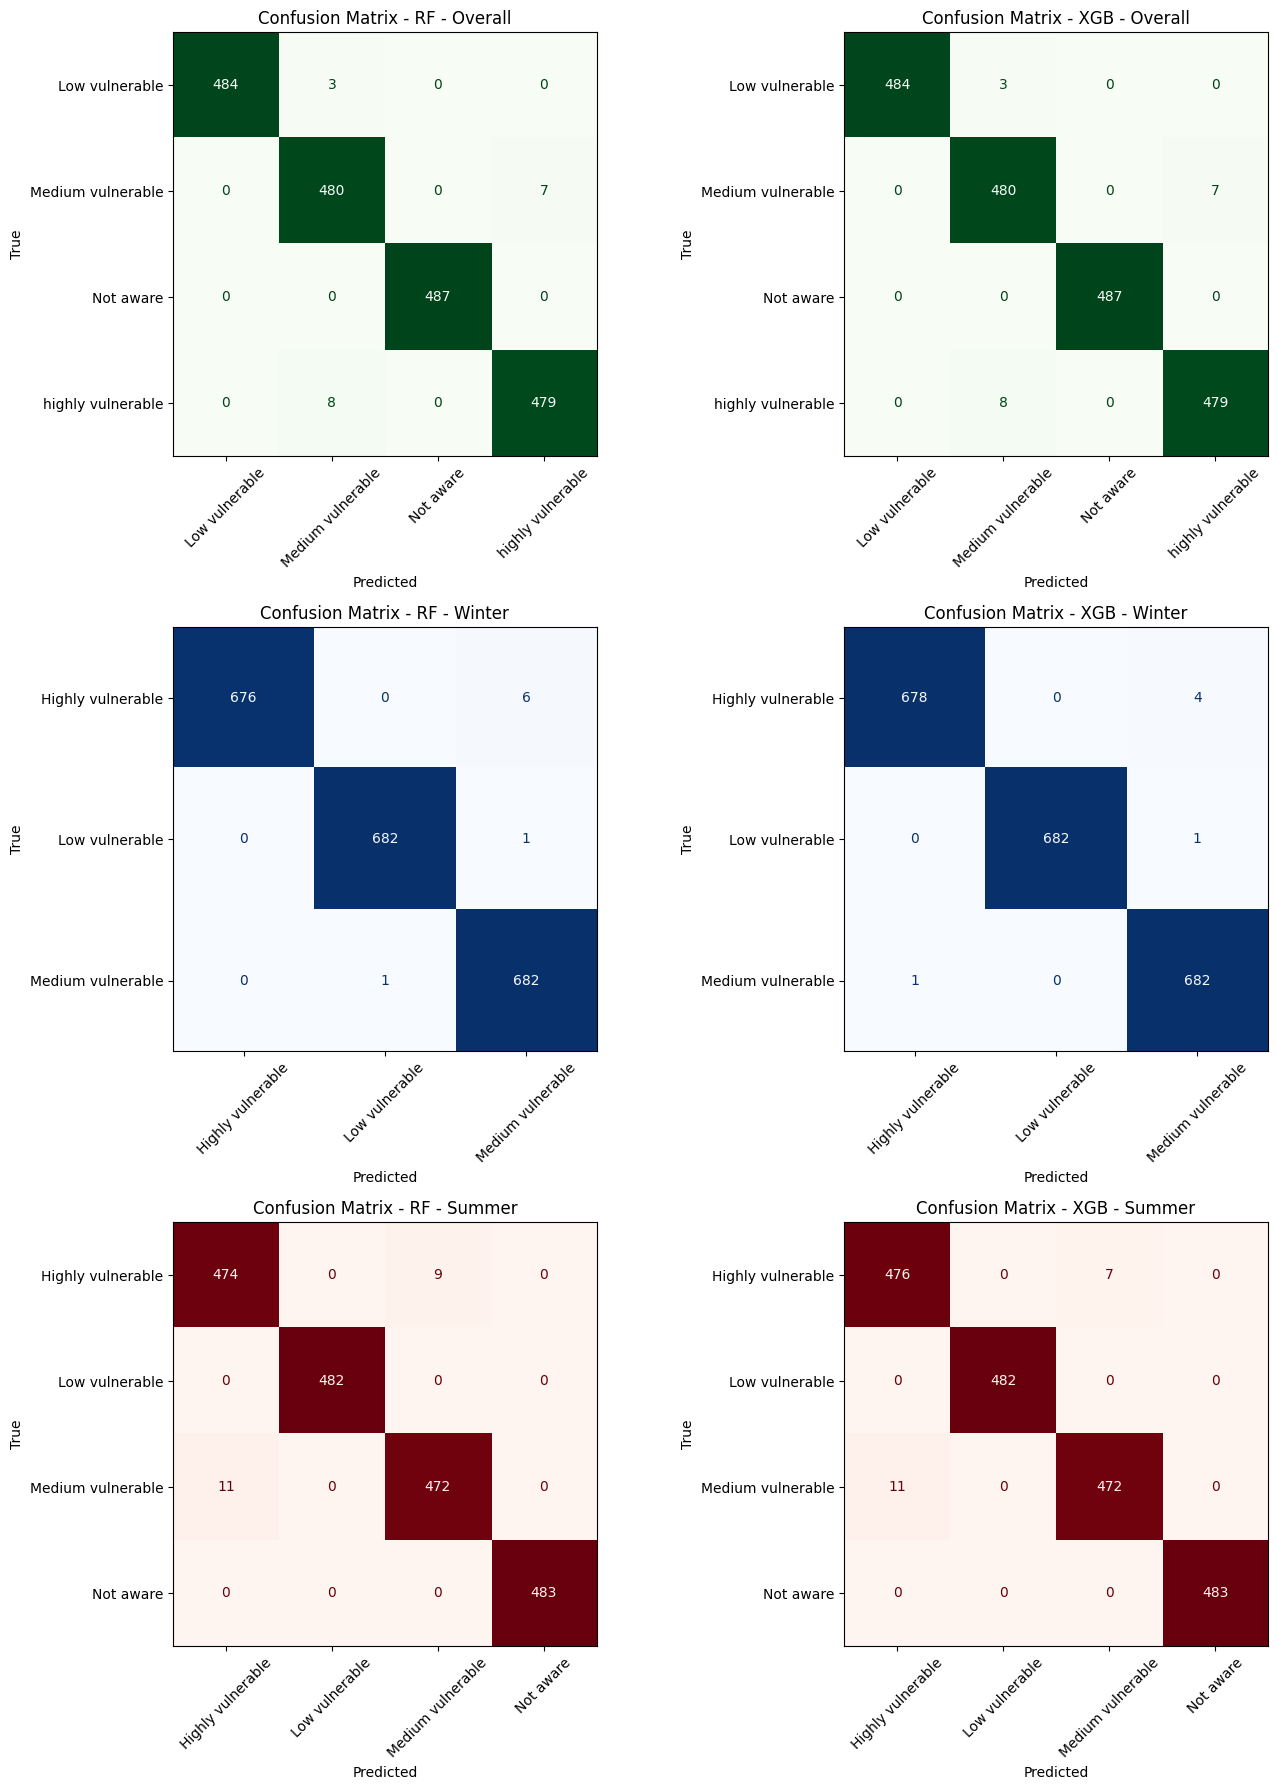

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(14, 18))  # 3 rows, 2 columns

# Row 1: Overall Vulnerability
plot_confusion_matrix_subplot(axes[0, 0], rf_total_model, X_total_bal, y_total_bal, le_total, title="Confusion Matrix - RF - Overall", cmap="Greens")
plot_confusion_matrix_subplot(axes[0, 1], xgb_total_model, X_total_bal, y_total_bal, le_total, title="Confusion Matrix - XGB - Overall", cmap="Greens")

# Row 2: Winter Vulnerability
plot_confusion_matrix_subplot(axes[1, 0], rf_winter_model, X_winter_bal, y_winter_bal, le_winter, title="Confusion Matrix - RF - Winter", cmap="Blues")
plot_confusion_matrix_subplot(axes[1, 1], xgb_winter_model, X_winter_bal, y_winter_bal, le_winter, title="Confusion Matrix - XGB - Winter", cmap="Blues")

# Row 3: Summer Vulnerability
plot_confusion_matrix_subplot(axes[2, 0], rf_summer_model, X_summer_bal, y_summer_bal, le_summer, title="Confusion Matrix - RF - Summer", cmap="Reds")
plot_confusion_matrix_subplot(axes[2, 1], xgb_summer_model, X_summer_bal, y_summer_bal, le_summer, title="Confusion Matrix - XGB - Summer", cmap="Reds")

plt.tight_layout()
plt.show()


In [10]:
# Combine CV metrics
cv_metrics_all = pd.concat([
    metrics_total_cv.assign(Model='Overall'),
    metrics_winter_cv.assign(Model='Winter'),
    metrics_summer_cv.assign(Model='Summer')
]).reset_index().rename(columns={'index': 'ML Model'})

display(cv_metrics_all)


,ML Model,Accuracy,F1 Score (macro),Precision (macro),Recall (macro),Model
0,Random Forest,0.990859,0.990870,0.990960,0.990852,Overall
1,XGBoost,0.990756,0.990762,0.990826,0.990751,Overall
2,Random Forest,0.995019,0.995022,0.995070,0.995019,Winter
3,XGBoost,0.994238,0.994238,0.994268,0.994237,Winter
4,Random Forest,0.989640,0.989643,0.989742,0.989639,Summer
5,XGBoost,0.989433,0.989434,0.989488,0.989432,Summer


**6. VARIABLE IMPORTANCE**

In [11]:
def plot_shap_multiclass_and_save_general(model, X, le_target, title="SHAP Summary Plot", filename="shap_plot.png"):
    # Compute SHAP values (TreeExplainer for Random Forest/XGBoost multiclass returns a list)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Ensure consistent class order
    sorted_class_names = sorted(le_target.classes_)

    # Plot SHAP summary with class names (force consistent order)
    shap.summary_plot(shap_values, X, plot_type="bar", class_names=sorted_class_names, show=False)
    plt.title(title)
    plt.savefig(filename, bbox_inches='tight')
    plt.close()


In [12]:
# Overall - Random Forest & XGBoost
plot_shap_multiclass_and_save_general(rf_total_model, pd.DataFrame(X_total_bal, columns=X_total_bal.columns), le_total,
                                      title="SHAP Summary - RF - Overall", filename="shap_rf_overall.png")

plot_shap_multiclass_and_save_general(xgb_total_model, pd.DataFrame(X_total_bal, columns=X_total_bal.columns), le_total,
                                      title="SHAP Summary - XGB - Overall", filename="shap_xgb_overall.png")

# Winter - Random Forest & XGBoost
plot_shap_multiclass_and_save_general(rf_winter_model, pd.DataFrame(X_winter_bal, columns=X_winter_bal.columns), le_winter,
                                      title="SHAP Summary - RF - Winter", filename="shap_rf_winter.png")

plot_shap_multiclass_and_save_general(xgb_winter_model, pd.DataFrame(X_winter_bal, columns=X_winter_bal.columns), le_winter,
                                      title="SHAP Summary - XGB - Winter", filename="shap_xgb_winter.png")

# Summer - Random Forest & XGBoost
plot_shap_multiclass_and_save_general(rf_summer_model, pd.DataFrame(X_summer_bal, columns=X_summer_bal.columns), le_summer,
                                      title="SHAP Summary - RF - Summer", filename="shap_rf_summer.png")

plot_shap_multiclass_and_save_general(xgb_summer_model, pd.DataFrame(X_summer_bal, columns=X_summer_bal.columns), le_summer,
                                      title="SHAP Summary - XGB - Summer", filename="shap_xgb_summer.png")


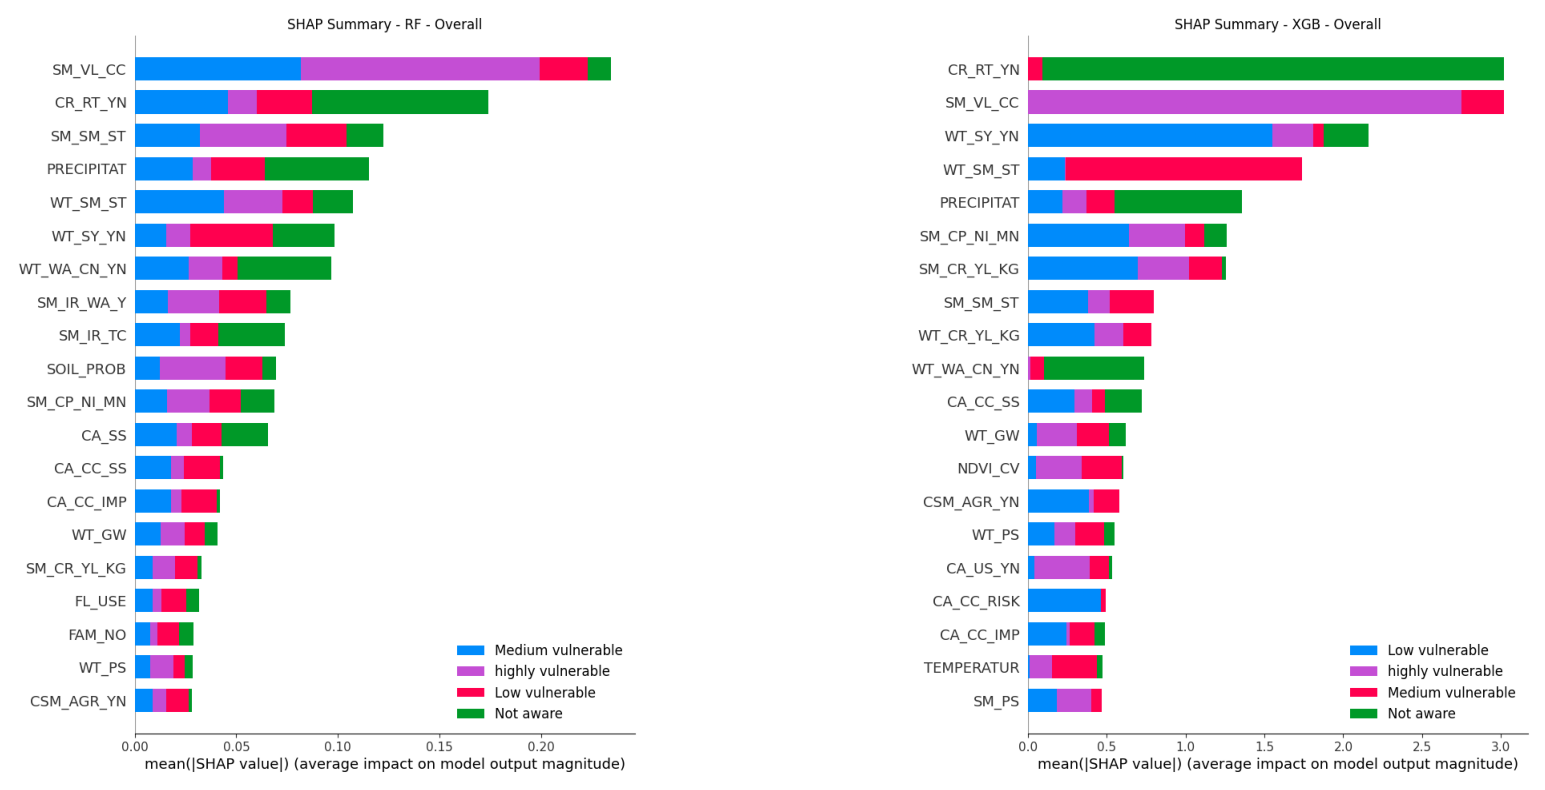

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

img_rf = mpimg.imread("shap_rf_overall.png")
axes[0].imshow(img_rf)
axes[0].axis('off')

img_xgb = mpimg.imread("shap_xgb_overall.png")
axes[1].imshow(img_xgb)
axes[1].axis('off')

plt.tight_layout()
plt.show()

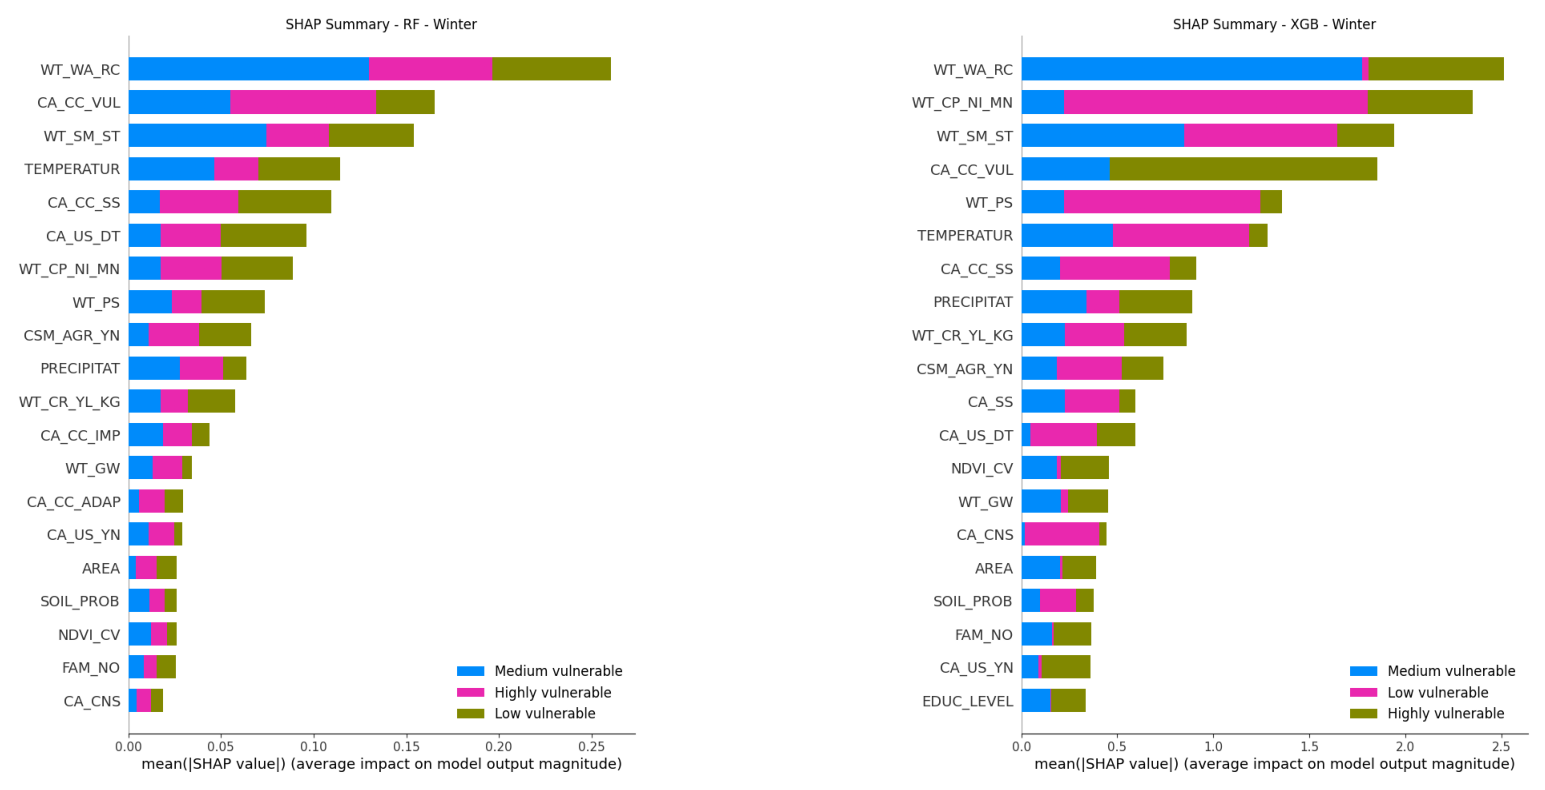

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

img_rf = mpimg.imread("shap_rf_winter.png")
axes[0].imshow(img_rf)
axes[0].axis('off')

img_xgb = mpimg.imread("shap_xgb_winter.png")
axes[1].imshow(img_xgb)
axes[1].axis('off')

plt.tight_layout()
plt.show()


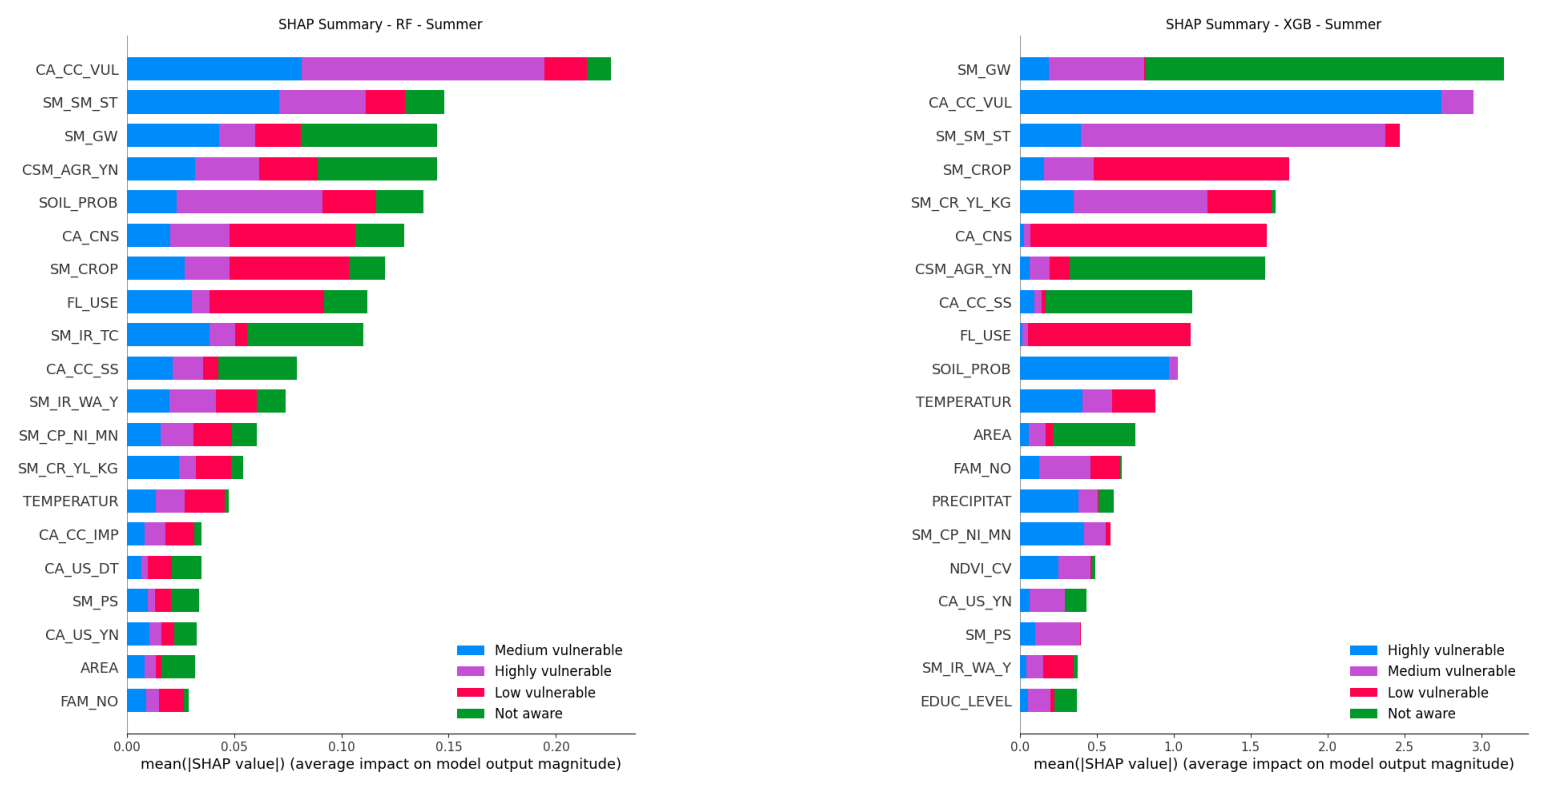

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

img_rf = mpimg.imread("shap_rf_summer.png")
axes[0].imshow(img_rf)
axes[0].axis('off')

img_xgb = mpimg.imread("shap_xgb_summer.png")
axes[1].imshow(img_xgb)
axes[1].axis('off')

plt.tight_layout()
plt.show()

**7. CLOUD WORD GRAPH**

In [16]:
def extract_top_shap_features(model, X, top_n=15):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    if isinstance(shap_values, list):  # Multiclass case
        # Each shap_values[i]: (samples, features)
        per_class_means = [np.abs(sv).mean(axis=0) for sv in shap_values]  # List of (features,)
        shap_abs_mean = np.mean(per_class_means, axis=0)  # Shape: (features,)
    else:  # Binary classification
        shap_abs_mean = np.abs(shap_values).mean(axis=0)  # Shape: (features,)

    # Ensure final shape (features,) even if it’s a 2D array
    if len(shap_abs_mean.shape) == 2:
        # Average over classes
        shap_abs_mean = shap_abs_mean.mean(axis=1)  # From (features, classes) → (features,)

    # Create feature importance series
    feature_importance = pd.Series(shap_abs_mean, index=X.columns).sort_values(ascending=False)

    # Get top N features
    top_features = list(feature_importance.index[:top_n])

    print(f"Top {top_n} SHAP Features:")
    for i, feature in enumerate(top_features, 1):
        print(f"{i}. {feature}")

    return top_features


In [17]:
# Overall
top_rf_overall = extract_top_shap_features(rf_total_model, pd.DataFrame(X_total_bal, columns=X_total_bal.columns), top_n=15)
top_xgb_overall = extract_top_shap_features(xgb_total_model, pd.DataFrame(X_total_bal, columns=X_total_bal.columns), top_n=15)

# Winter
top_rf_winter = extract_top_shap_features(rf_winter_model, pd.DataFrame(X_winter_bal, columns=X_winter_bal.columns), top_n=15)
top_xgb_winter = extract_top_shap_features(xgb_winter_model, pd.DataFrame(X_winter_bal, columns=X_winter_bal.columns), top_n=15)

# Summer
top_rf_summer = extract_top_shap_features(rf_summer_model, pd.DataFrame(X_summer_bal, columns=X_summer_bal.columns), top_n=15)
top_xgb_summer = extract_top_shap_features(xgb_summer_model, pd.DataFrame(X_summer_bal, columns=X_summer_bal.columns), top_n=15)

Top 15 SHAP Features:
1. SM_VL_CC
2. CR_RT_YN
3. SM_SM_ST
4. PRECIPITAT
5. WT_SM_ST
6. WT_SY_YN
7. WT_WA_CN_YN
8. SM_IR_WA_Y
9. SM_IR_TC
10. SOIL_PROB
11. SM_CP_NI_MN
12. CA_SS
13. CA_CC_SS
14. CA_CC_IMP
15. WT_GW
Top 15 SHAP Features:
1. CR_RT_YN
2. SM_VL_CC
3. WT_SY_YN
4. WT_SM_ST
5. PRECIPITAT
6. SM_CP_NI_MN
7. SM_CR_YL_KG
8. SM_SM_ST
9. WT_CR_YL_KG
10. WT_WA_CN_YN
11. CA_CC_SS
12. WT_GW
13. NDVI_CV
14. CSM_AGR_YN
15. WT_PS
Top 15 SHAP Features:
1. WT_WA_RC
2. CA_CC_VUL
3. WT_SM_ST
4. TEMPERATUR
5. CA_CC_SS
6. CA_US_DT
7. WT_CP_NI_MN
8. WT_PS
9. CSM_AGR_YN
10. PRECIPITAT
11. WT_CR_YL_KG
12. CA_CC_IMP
13. WT_GW
14. CA_CC_ADAP
15. CA_US_YN
Top 15 SHAP Features:
1. WT_WA_RC
2. WT_CP_NI_MN
3. WT_SM_ST
4. CA_CC_VUL
5. WT_PS
6. TEMPERATUR
7. CA_CC_SS
8. PRECIPITAT
9. WT_CR_YL_KG
10. CSM_AGR_YN
11. CA_SS
12. CA_US_DT
13. NDVI_CV
14. WT_GW
15. CA_CNS
Top 15 SHAP Features:
1. CA_CC_VUL
2. SM_SM_ST
3. SM_GW
4. CSM_AGR_YN
5. SOIL_PROB
6. CA_CNS
7. SM_CROP
8. FL_USE
9. SM_IR_TC
10. CA_CC_SS
11.

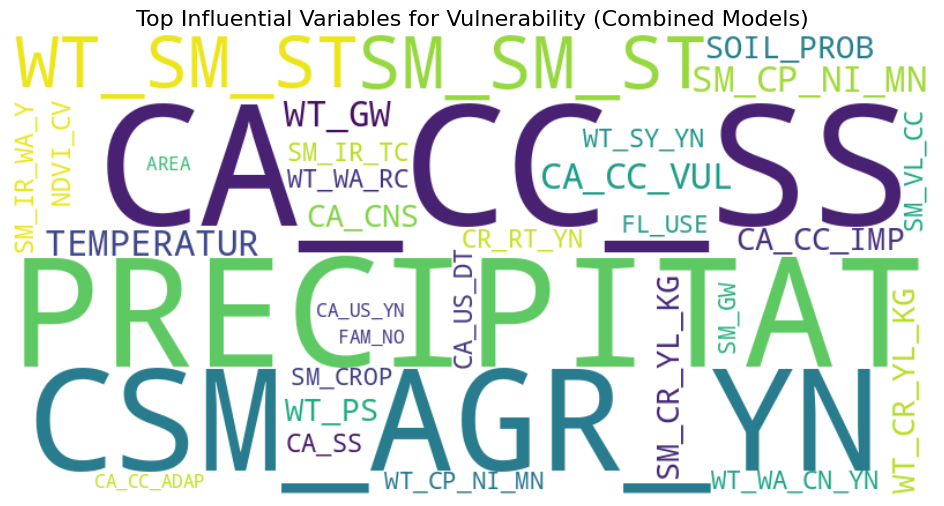

In [18]:
# Combine all variables
all_top_features = top_rf_overall + top_xgb_overall + top_rf_winter + top_xgb_winter + top_rf_summer + top_xgb_summer

# Frequency count
from collections import Counter
feature_counts = Counter(all_top_features)

# Generate word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(feature_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Influential Variables for Vulnerability (Combined Models)", fontsize=16)
plt.show()
